In [1]:
#Import dependencies
from tradingview_ta import TA_Handler, Interval
from finta import TA
from pyod.models.copod import COPOD
import pandas as pd 
import nltk
import time
import numpy as np
from pycoingecko import CoinGeckoAPI
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
from dotenv import load_dotenv
from datetime import datetime
import re
import json
import os
import ast
import tweepy
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
load_dotenv()
cg = CoinGeckoAPI()
coins = cg.get_coins()
screener = 'CRYPTO'

consumer_key = os.getenv("consumer_key")
consumer_secret = os.getenv("consumer_secret")
access_token = os.getenv("access_token")
access_secret = os.getenv("access_secret")


reddit_id = os.getenv("reddit_id")
reddit_key = os.getenv("reddit_key")
data = ast.literal_eval(os.getenv("reddit_data"))
auth = requests.auth.HTTPBasicAuth(reddit_id, reddit_key)
headers = {'User-Agent': 'TaraRedditApi/0.0.1'}

res = requests.post('https://www.reddit.com/api/v1/access_token',
                   auth=auth, data=data, headers=headers)

TOKEN = res.json()['access_token']
headers['Authorization'] = f'bearer{TOKEN}'

#create authentication object
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret)

#set the access token and secret token 
authenticate.set_access_token(access_token, access_secret)

#create api object while passing in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

tickers = []
for i in coins:
  tickers.append(i['symbol'])
print('')
print('Extracted top fifty market cap coins from CoinGeckoAPI')
print('')

#Format prices for TradingView inputs
for i in range(len(tickers)):
  tickers[i] = tickers[i].upper()

denomination = 'USD'
tickers_denominated = [x + denomination for x in tickers]
print('Top Fifty Market Cap Cryptocurrencies')
print('')
print(tickers_denominated)


Extracted top fifty market cap coins from CoinGeckoAPI

Top Fifty Market Cap Cryptocurrencies

['BTCUSD', 'ETHUSD', 'BNBUSD', 'USDTUSD', 'SOLUSD', 'ADAUSD', 'XRPUSD', 'DOTUSD', 'USDCUSD', 'DOGEUSD', 'SHIBUSD', 'LUNAUSD', 'AVAXUSD', 'LTCUSD', 'WBTCUSD', 'LINKUSD', 'BUSDUSD', 'BCHUSD', 'ALGOUSD', 'MATICUSD', 'CROUSD', 'VETUSD', 'UNIUSD', 'XLMUSD', 'AXSUSD', 'ATOMUSD', 'TRXUSD', 'ICPUSD', 'DAIUSD', 'FTTUSD', 'FILUSD', 'CETHUSD', 'ETCUSD', 'OKBUSD', 'THETAUSD', 'STETHUSD', 'HBARUSD', 'FTMUSD', 'EGLDUSD', 'NEARUSD', 'USTUSD', 'GRTUSD', 'XTZUSD', 'XMRUSD', 'HNTUSD', 'EOSUSD', 'CAKEUSD', 'CDAIUSD', 'MANAUSD', 'FLOWUSD']


In [2]:
#Grab indicator recommendations from Trading View API
print(f'Extracting analyst recommendations (buys and strong buys)')
from tradingview_ta import TA_Handler, Interval, Exchange
staging_df = pd.DataFrame()
binance_daily = pd.DataFrame()
coinbase_daily = pd.DataFrame()
for ticker in tickers_denominated:
    try:
        data = (TA_Handler(symbol=ticker,screener=screener,
                        exchange='BINANCE',interval=Interval.INTERVAL_1_DAY ).get_analysis().summary)
        symbol = ticker
        staging_df = list(data.values())
        final_df = (pd.DataFrame((data), index={ticker}))
        binance_daily = binance_daily.append(final_df)
    except:
        print(f'{ticker} not listed on Binance, checking Coinbase')
        pass

for ticker in tickers_denominated:
    try:
        data = (TA_Handler(symbol=ticker,screener=screener,
                        exchange='COINBASE',interval=Interval.INTERVAL_1_DAY ).get_analysis().summary)
        symbol = ticker
        staging_df = list(data.values())
        final_df = (pd.DataFrame((data), index={ticker}))
        coinbase_daily = coinbase_daily.append(final_df)
    except:
        pass
print(f'finished extracting analyst recommendations..')


indicators = pd.concat([coinbase_daily,binance_daily], axis='columns', join='outer')
indicators = indicators['RECOMMENDATION']
indicators.columns = ['binance', 'coinbase']
analyst_recommendations = indicators['binance'].combine_first(indicators['coinbase'])
analyst_recommendations = analyst_recommendations[~analyst_recommendations.str.contains("SELL", na=False)]
analyst_recommendations = analyst_recommendations[~analyst_recommendations.str.contains("STRONG_SELL", na=False)]
analyst_recommendations.to_csv('Data/tickers.csv')
cryptos = analyst_recommendations.index.values.tolist()
print(cryptos)

Extracting analyst recommendations (buys and strong buys)
USDTUSD not listed on Binance, checking Coinbase
USDCUSD not listed on Binance, checking Coinbase
SHIBUSD not listed on Binance, checking Coinbase
BUSDUSD not listed on Binance, checking Coinbase
CROUSD not listed on Binance, checking Coinbase
DAIUSD not listed on Binance, checking Coinbase
CETHUSD not listed on Binance, checking Coinbase
OKBUSD not listed on Binance, checking Coinbase
STETHUSD not listed on Binance, checking Coinbase
USTUSD not listed on Binance, checking Coinbase
CDAIUSD not listed on Binance, checking Coinbase
finished extracting analyst recommendations..
['BTCUSD', 'ETHUSD', 'SOLUSD', 'DOTUSD', 'SHIBUSD', 'AVAXUSD', 'LTCUSD', 'WBTCUSD', 'LINKUSD', 'BCHUSD', 'ALGOUSD', 'MATICUSD', 'CROUSD', 'XLMUSD', 'AXSUSD', 'ATOMUSD', 'USTUSD', 'GRTUSD', 'EOSUSD', 'MANAUSD', 'BNBUSD', 'XRPUSD', 'LUNAUSD', 'VETUSD', 'TRXUSD', 'HBARUSD', 'FTMUSD', 'EGLDUSD', 'NEARUSD', 'XMRUSD', 'HNTUSD']


C:\Users\jteel\anaconda3\envs\ml\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


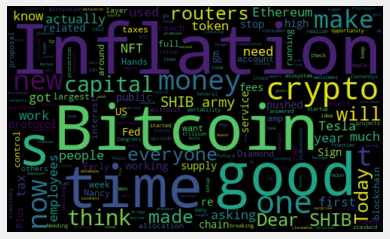

In [3]:
ticker_names = pd.read_csv('Data/ticker_names.csv', index_col='Description')
top_fifty = pd.read_csv('Data/tickers.csv', index_col='Unnamed: 0')
top_fifty = top_fifty.index.values.tolist()
nlp_cryptos = ticker_names[ticker_names['Ticker'].isin(top_fifty)]
nlp_cryptos.drop_duplicates(inplace=True)
nlp_cryptos = nlp_cryptos.index.values.tolist()

for i in range(len(nlp_cryptos)):
  nlp_cryptos[i] = nlp_cryptos[i].lower()
  
%run NLP.ipynb

In [4]:
#Configure algo strategy
def algo_strategy(time_series):
    buy_price=0
    trend_cnt=0
    dtrend_cnt=0
    maker_fee = .01
    sell_price=0
    profit =0
    accumulated_profit = 0
    previous_price = 0
    previous_returns = 0
    previous_candle = 'downtrend'
    classification = 'SELL'
    previous_classification = 'SELL'
    candle = 0
    ema = 0
    stochastic = 0
    time_series['trading'] = np.nan
    for index, row in time_series.iterrows():
        if row["candle"] < 0:
            candle = 'downtrend'
        else:
            candle = 'uptrend'
        if row["returns"] < 0:
            returns = 'downtrend'
        else: 
            returns = 'uptrend'
        if row['stoch_k'] > row['stoch_d']:
            stochastic = 'uptrend'
        else:
            stochastic = 'downtrend'
        if row['short_vama'] > row['long_vama']:
            vama = 'uptrend'
        else:
            vama = 'downtrend'
        if row['short_ema'] > row['long_ema']:
            ema = 'uptrend'
        else:
            ema = 'downtrend'
        if index == time_series.index[0]:
            time_series.loc[index, "trading"] = previous_classification
        elif (candle=='uptrend') and (returns=='uptrend') and (vama=='uptrend') and (ema=='uptrend') and (previous_classification=='SELL'):
            classification ='BUY'
            buy_price = row['close']
            time_series.loc[index, "trading"] = classification
        elif (candle=='uptrend') and (returns=='uptrend') and (vama=='uptrend') and (ema=='uptrend') and (previous_classification=='BUY'):
            classification ='HOLD'
            time_series.loc[index, "trading"] = classification
        elif (candle=='uptrend') and (returns=='uptrend') and (vama=='uptrend') and (ema=='uptrend') and (previous_classification=='HOLD'):
            classification ='HOLD'
            time_series.loc[index, "trading"] = classification
        elif (candle=='downtrend') and (previous_candle=='downtrend') and (returns=='downtrend') and (previous_returns=='downtrend') and (previous_classification=='HOLD') and (row['close'] > buy_price):
            classification ='SELL'
            sell_price = row['close']
            profit = ((sell_price - buy_price)*(1-maker_fee))
            accumulated_profit = (accumulated_profit+profit)
            time_series.loc[index, "profit"] = (profit + accumulated_profit)
            time_series.loc[index, "trading"] = classification
        elif (candle=='downtrend') and (previous_candle=='downtrend') and (returns=='downtrend') and (previous_returns=='downtrend') and (previous_classification=='BUY') and (row['close'] > buy_price):
            classification ='SELL'
            sell_price = row['close']
            profit = ((sell_price - buy_price)*(1-maker_fee))
            accumulated_profit = (accumulated_profit+profit)
            time_series.loc[index, "trading"] = classification
        elif previous_classification=='BUY' and classification==previous_classification:
            classification ='HOLD'
            time_series.loc[index, "trading"] = classification
        elif previous_classification=='SELL' and classification==previous_classification:
            classification=='SELL'
            time_series.loc[index, "trading"] = classification
        else:
            classification=previous_classification
            time_series.loc[index, "trading"] = classification
        if candle == 'uptrend' and previous_candle=='uptrend':
            trend_cnt = trend_cnt+1
            time_series.loc[index, "trend_cnt"] = trend_cnt
        else: 
            trend_cnt=0
            time_series.loc[index, "trend_cnt"] = trend_cnt
        if candle == 'downtrend' and previous_candle=='downtrend':
            dtrend_cnt = dtrend_cnt+1
            time_series.loc[index, "dtrend_cnt"] = dtrend_cnt
        else: 
            dtrend_cnt=0
            time_series.loc[index, "dtrend_cnt"] = dtrend_cnt

        if trend_cnt==4 and classification=='HOLD' and ((row['close'] > buy_price)>0.75):
            classification ='SELL'
            sell_price = row['close']
            profit = ((sell_price - buy_price)*(1-maker_fee))
            accumulated_profit = (accumulated_profit+profit)
            time_series.loc[index, "trading"] = classification

        time_series.loc[index, "profit"] = accumulated_profit
        previous_classification=classification
        previous_candle = candle
        previous_returns = returns

In [5]:
#Connect to websocket
import logging
tradev_id = os.getenv("username")
tradev_secret_key = os.getenv("password_tv")
from tvDatafeed import TvDatafeed,Interval
tv = TvDatafeed(tradev_id, tradev_secret_key, chromedriver_path=None)

In [6]:
#Get historical pricing information for total population, us FinTa to calculate oscillator and momentum indicators
crypto_data = pd.DataFrame()
short_window = 10
long_window = 20
try:
    for tickers in cryptos:
        try:
            data = tv.get_hist(
                symbol=tickers,
                exchange='BINANCE',
                interval=Interval.in_2_hour,n_bars=10000)
            data['candle'] = (data['close'] - data['open'])
            bbands_df = TA.BBANDS(data)
            data['bb_upper'] = bbands_df['BB_UPPER']
            data['bb_middle'] = bbands_df['BB_MIDDLE']
            data['bb_lower'] = bbands_df['BB_LOWER']
            data['returns'] = data['close'].pct_change()
            data['stoch_k'] = TA.STOCH(data)
            data['stoch_d'] = TA.STOCHD(data)
            data['short_ema'] = TA.EMA(data, short_window)
            data['long_ema'] = TA.EMA(data, long_window)
            data['short_vama'] = TA.VAMA(data, short_window)
            data['long_vama'] = TA.VAMA(data, long_window)
            data.dropna(inplace=True)
            data[['exchange', 'ticker']] = data['symbol'].str.split(':',expand=True)
            data=data.drop(columns=["symbol"])
            data=data.drop(columns=["exchange"])
            clf = COPOD()
            X = data.iloc[:,:15]
            clf.fit(X)
            y_train_pred = clf.labels_
            data['anomoly'] = y_train_pred
            algo_strategy(data)
            data.to_csv(f'Data/Functionality/Algo_Bot/{tickers}.csv')
            crypto_data = crypto_data.append(data)
        except:
            data = tv.get_hist(
                symbol=tickers,
                exchange='COINBASE',
                interval=Interval.in_2_hour,n_bars=10000)
            data['candle'] = (data['close'] - data['open'])
            bbands_df = TA.BBANDS(data)
            data['bb_upper'] = bbands_df['BB_UPPER']
            data['bb_middle'] = bbands_df['BB_MIDDLE']
            data['bb_lower'] = bbands_df['BB_LOWER']
            data['returns'] = data['close'].pct_change()
            data['stoch_k'] = TA.STOCH(data)
            data['stoch_d'] = TA.STOCHD(data)
            data['short_ema'] = TA.EMA(data, short_window)
            data['long_ema'] = TA.EMA(data, long_window)
            data['short_vama'] = TA.VAMA(data, short_window)
            data['long_vama'] = TA.VAMA(data, long_window)
            data.dropna(inplace=True)
            data[['exchange', 'ticker']] = data['symbol'].str.split(':',expand=True)
            data=data.drop(columns=["symbol"])
            data=data.drop(columns=["exchange"])
            clf = COPOD()
            X = data.iloc[:,:15]
            clf.fit(X)
            y_train_pred = clf.labels_
            data['anomoly'] = y_train_pred
            algo_strategy(data)
            data.to_csv(f'Data/Functionality/Algo_Bot/{tickers}.csv')
            crypto_data = crypto_data.append(data)
except:
    print('ERROR: Check for websocket upgrade, ensure dependencies in requirements.txt are installed, or try CONDA UPDATE CONDA')
print(f'Extracted prices and calculated oscillator/momentum indicator values')


dataset = crypto_data.copy()
isolation = dict()
for k, v in dataset.groupby('ticker'):
    isolation[k] = v
isolation['BTCUSD']

ERROR:tvDatafeed.main:Connection is already closed.
ERROR:tvDatafeed.main:Connection is already closed.
ERROR:tvDatafeed.main:Connection is already closed.


Extracted prices and calculated oscillator/momentum indicator values


,open,high,low,close,volume,candle,bb_upper,bb_middle,bb_lower,returns,...,short_ema,long_ema,short_vama,long_vama,ticker,anomoly,trading,trend_cnt,dtrend_cnt,profit
datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-27 03:00:00,10699.600000,10702.670320,10643.671330,10678.293840,108.929604,-21.306160,10829.919524,10760.815444,10691.711364,-0.002783,...,10754.438143,10748.545256,10762.205004,10768.429679,BTCUSD,1,SELL,0.0,1.0,0.000000
2020-09-27 05:00:00,10678.293840,10712.206920,10674.583870,10676.526080,113.896900,-1.767760,10835.061750,10756.409061,10677.756372,-0.000166,...,10740.267686,10741.558751,10750.844927,10761.119558,BTCUSD,1,SELL,0.0,2.0,0.000000
2020-09-27 07:00:00,10675.223520,10733.327000,10641.973350,10720.789860,102.498498,45.566340,10832.328955,10753.255005,10674.181055,0.004146,...,10736.725316,10739.547545,10742.585724,10719.095337,BTCUSD,1,SELL,0.0,0.0,0.000000
2020-09-27 09:00:00,10725.418600,10781.010000,10668.710720,10781.010000,119.807059,55.591400,10835.061698,10755.616476,10676.171255,0.005617,...,10744.778838,10743.556252,10745.167060,10751.105457,BTCUSD,1,SELL,1.0,0.0,0.000000
2020-09-27 11:00:00,10781.010000,10808.701030,10745.794360,10763.006760,135.914225,-18.003240,10835.882106,10757.155707,10678.429308,-0.001670,...,10748.093598,10745.434070,10745.273330,10755.394355,BTCUSD,1,SELL,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15 04:00:00,66040.173650,66123.861284,65671.397205,65817.599900,111022.230430,-222.573750,66364.820242,65200.086449,64035.352657,-0.003394,...,65601.670145,65297.127585,65702.273967,65516.025265,BTCUSD,0,HOLD,0.0,0.0,55564.886003
2021-11-15 06:00:00,65823.940180,66026.231152,65398.556080,65557.008407,121525.001310,-266.931773,66392.614524,65243.490118,64094.365712,-0.003959,...,65593.549829,65321.878139,65750.785909,65528.698830,BTCUSD,0,HOLD,0.0,1.0,55564.886003
2021-11-15 08:00:00,65557.008407,65561.589669,64298.541000,64326.077211,193177.087090,-1230.931196,66424.182799,65222.279475,64020.376150,-0.018777,...,65363.100262,65227.039956,65643.310525,65403.747678,BTCUSD,1,HOLD,0.0,2.0,55564.886003
